In [64]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPop
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad
import seaborn as sns
import networkx as nx

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [65]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "figure2", "processed", "adata_processed_with_paths_magic.h5ad")
                     )

In [66]:
len(adata)

7296

In [67]:
def get_cell_indices(adata):
    # Get the indices of cells for the different populations
    cmp_cells = list(adata.obs[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].index.astype("int"))
    unsorted_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Unsorted myeloid'].index.astype("int"))
    cebpa_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpa KO'].index.astype("int"))
    cebpe_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpe KO'].index.astype("int"))

    return cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells

In [68]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
cmp_unsorted_adata = adata[cmp_cells + unsorted_cells]

## Model

In [69]:
batch_size = cmp_unsorted_adata.shape[0] // 2
n_latent = 0

In [70]:
print(batch_size)

2112


In [71]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

## Load weights

In [72]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                             "trained_mycellpop_24_jul_19_2.pt"), 
                                map_location=torch.device('cpu'))

In [73]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

## Plotting

In [74]:
sc.pp.neighbors(cmp_unsorted_adata, n_neighbors=30, n_pcs=50)

In [75]:
with torch.no_grad():
    
    unsorted_velocities = []
        
    for i in tqdm(range(cmp_unsorted_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cmp_unsorted_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        velocity = mycellpop.get_derivatives(gene_expr)

        unsorted_velocities.append(velocity)
        
unsorted_velocities = torch.cat(unsorted_velocities).cpu().numpy()[:, :, 0]
cmp_unsorted_adata.layers["velocity"] = unsorted_velocities
cmp_unsorted_adata.layers["X"] = cmp_unsorted_adata.X

100%|██████████| 2/2 [00:42<00:00, 21.41s/it]


In [76]:
scv.tl.velocity_graph(cmp_unsorted_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:29) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


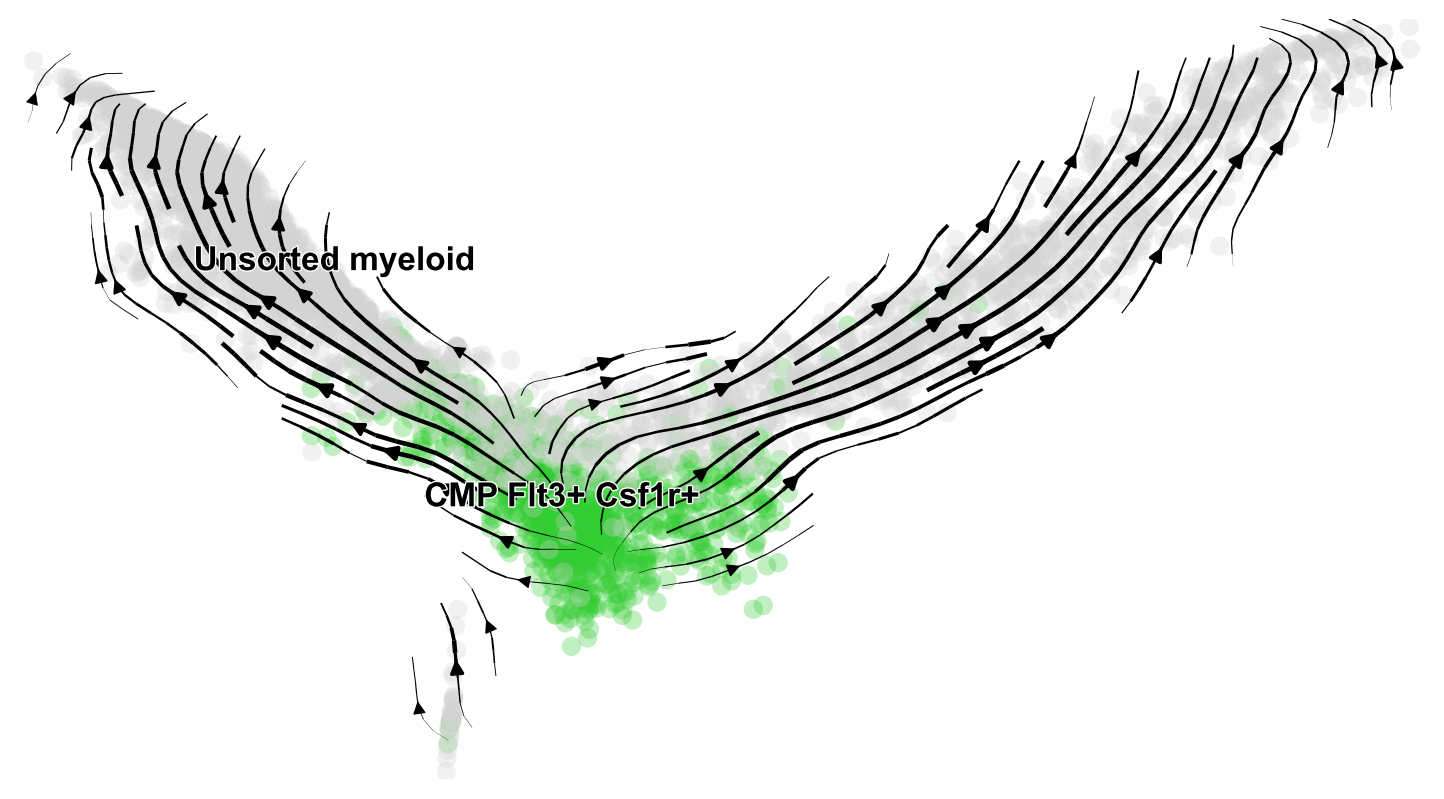

In [77]:
plt.rcParams["figure.figsize"] = (9,5)
scv.pl.velocity_embedding_stream(cmp_unsorted_adata, basis='umap', color="Batch_desc", layer="obs", palette=["limegreen", "lightgrey"], title="")

## Learnt interaction matrix

In [82]:
plt.rcParams["figure.figsize"] = (2,1.3)

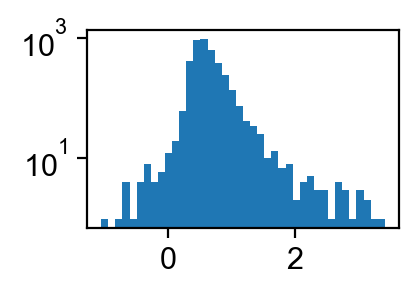

In [83]:
plt.hist(mycellpop["gene"].alpha.data.numpy().reshape(-1), bins=40)
plt.yscale("log")
# plt.title("alpha")
plt.show()

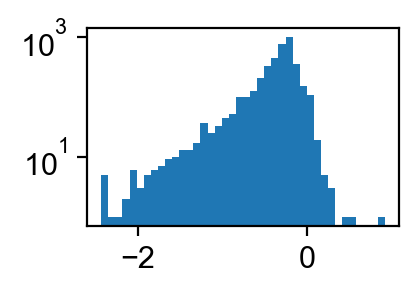

In [84]:
plt.hist(mycellpop["gene"].bias.data.numpy().reshape(-1), bins=40)
# plt.title("bias")
plt.yscale("log")
plt.show()

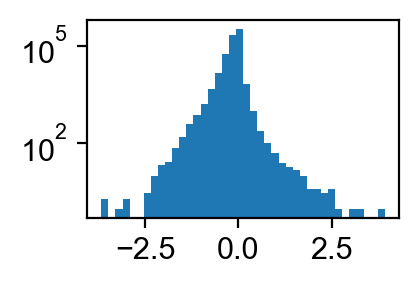

In [85]:
plt.hist(mycellpop["gene", "regulates", "gene"].simple_conv_weights.data.numpy().reshape(-1), bins=40)
# plt.title("interaction strength")
plt.yscale("log")
plt.show()

In [19]:
mycellpop["gene"]

NodeSet(idx_low=0, idx_high=4000, node attributes: ['name', 'bias', 'alpha'])

In [20]:
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data.shape

torch.Size([1, 615164, 1])

In [21]:
graph_edges = mycellpop["gene", "regulates", "gene"].edges.numpy().tolist()
graph_edges = [e + [{"strength": mycellpop["gene", "regulates", "gene"].simple_conv_weights.data[0, i].item()}]
               for i, e in enumerate(graph_edges)]

In [22]:
g = nx.DiGraph()
g.add_nodes_from(range(4000))
g.add_edges_from(graph_edges)
nx.set_node_attributes(g, {i: mycellpop["gene"].name[i] for i in range(4000)}, name="name")

In [23]:
g.number_of_nodes()

4000

In [24]:
g.number_of_edges()

615164

In [25]:
np.random.seed(6)
sub_g = g.subgraph(np.random.randint(4000, size=50))


In [26]:
# largest_cc = max(nx.connected_components(sub_g.to_undirected()), key=len)

In [27]:
# sub_g = g.subgraph(largest_cc)

In [28]:
pos=nx.spring_layout(sub_g, k=2.5)

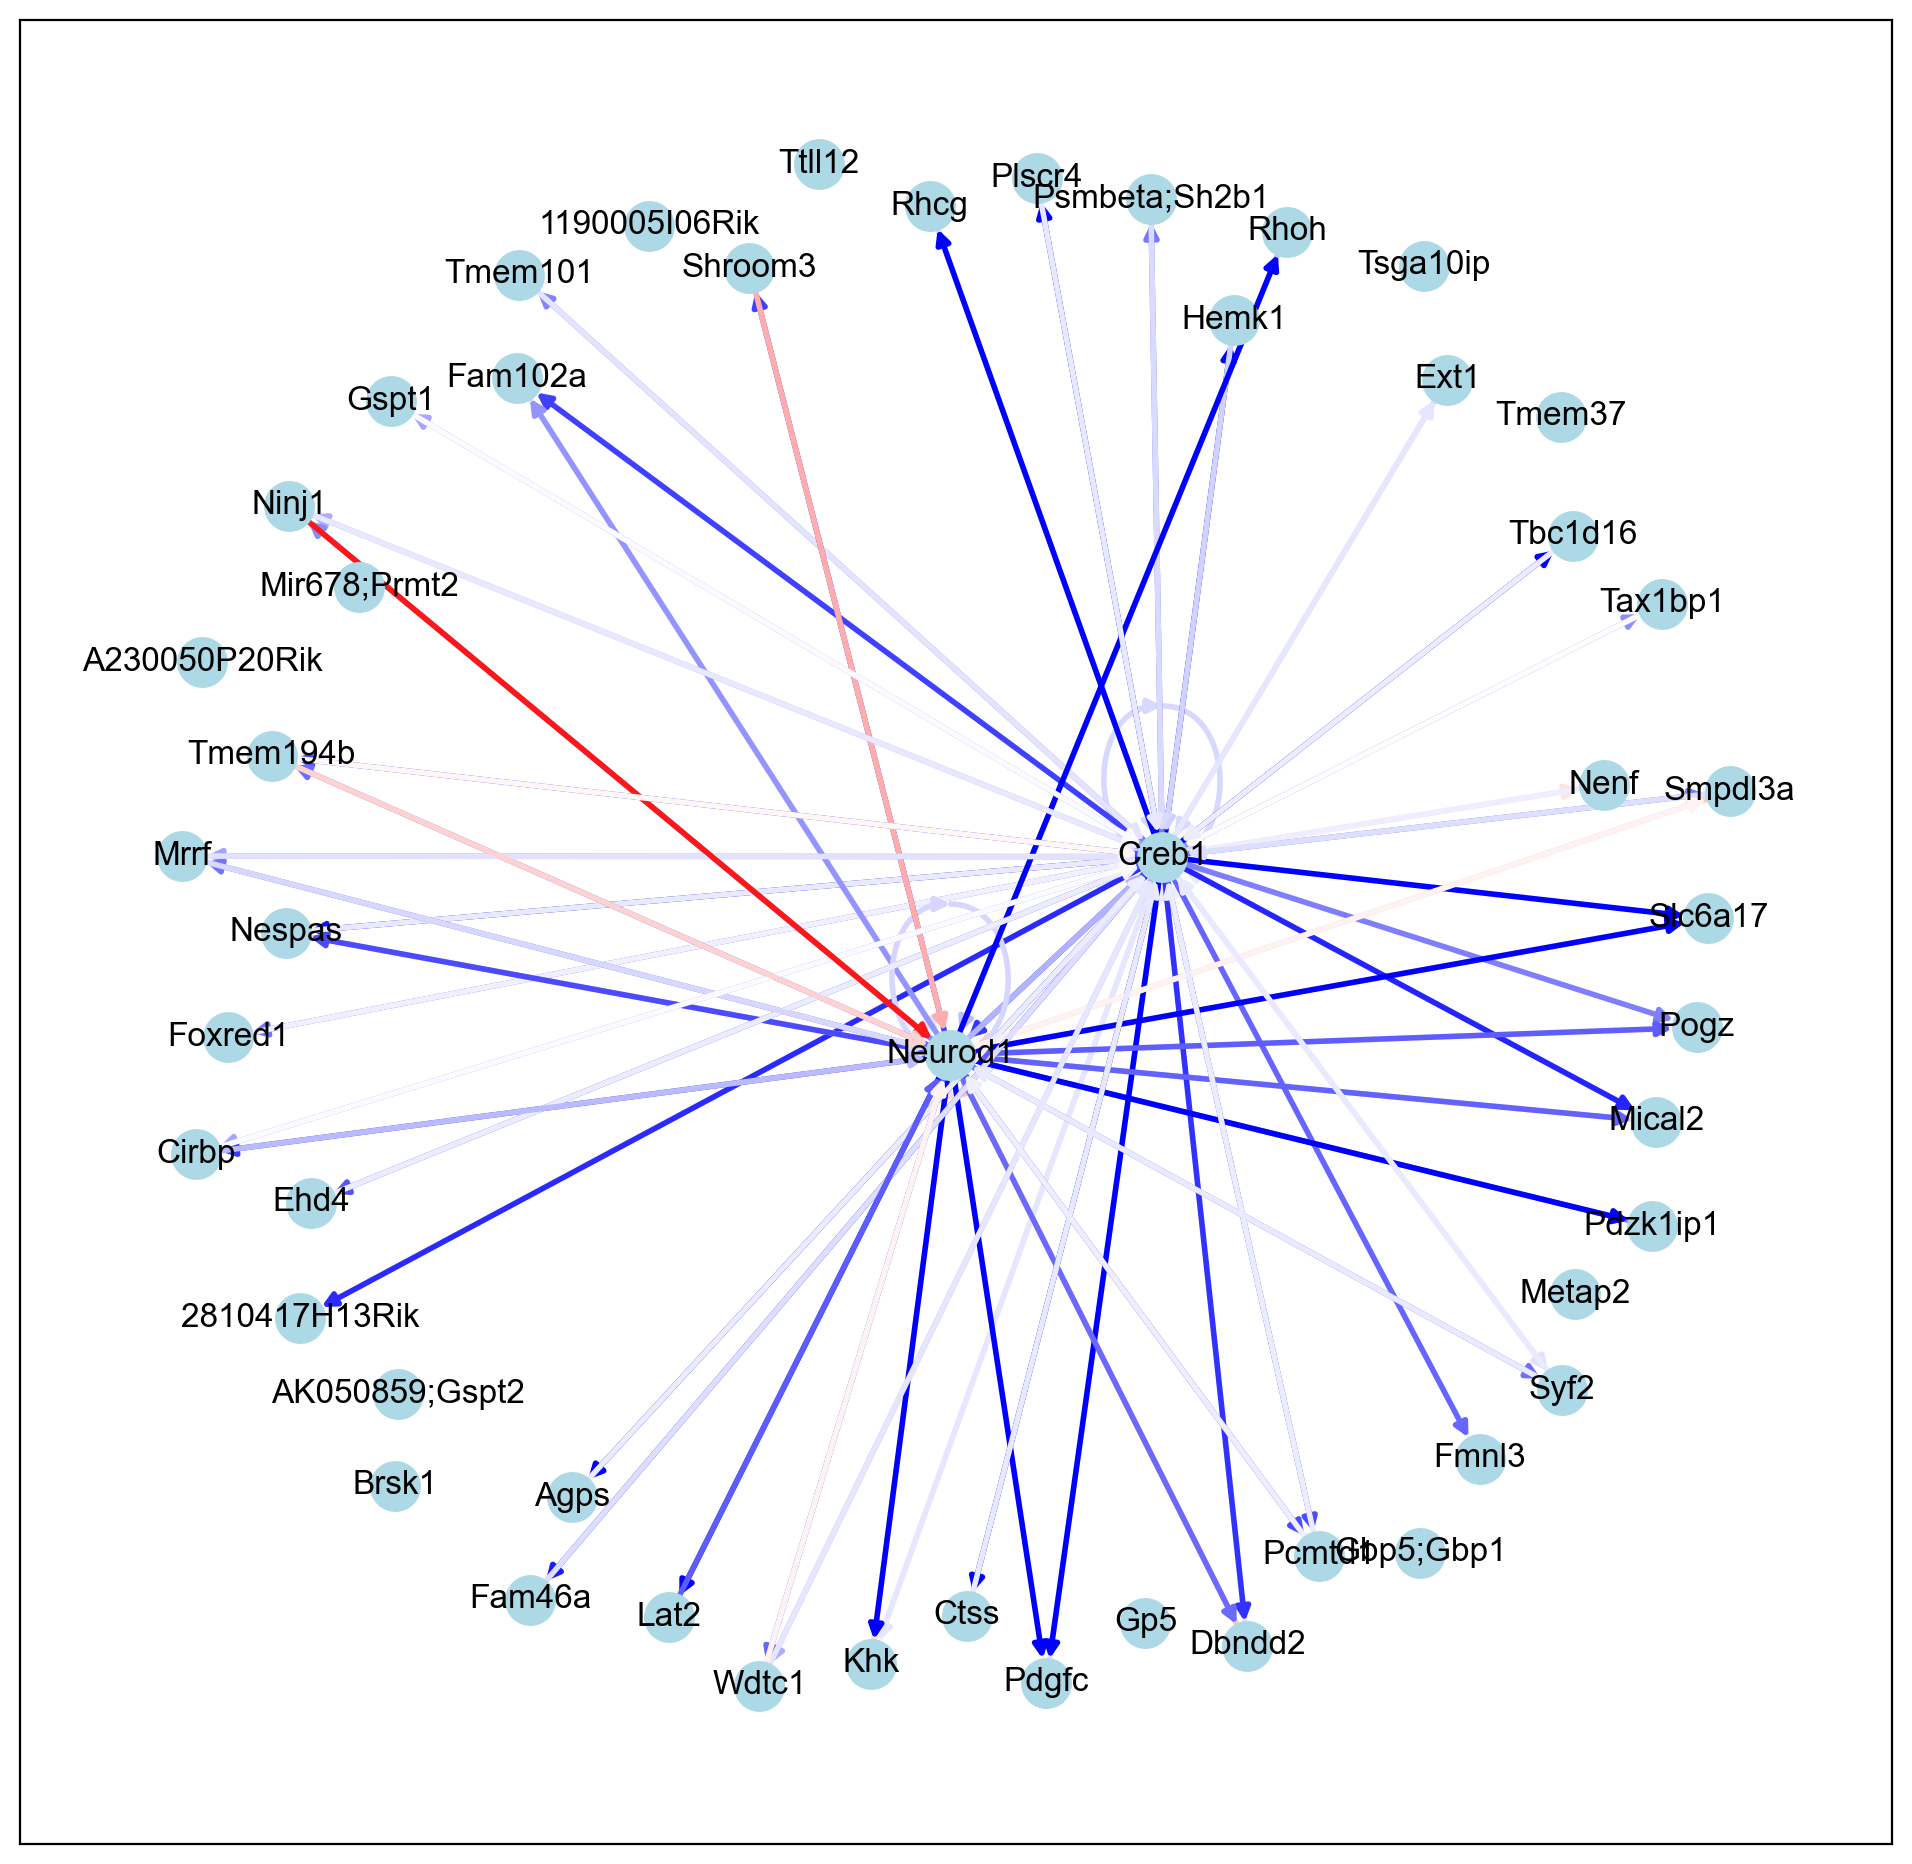

In [29]:
plt.rcParams["figure.figsize"] = (12, 12)
nx.draw_networkx(sub_g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(sub_g,'strength').values()),
        edge_cmap= plt.get_cmap('bwr'),  # plt.cm.plasma,
        with_labels = True,
        labels=nx.get_node_attributes(sub_g, "name"),
        edge_vmin=-0.3, edge_vmax=0.3,
        width=2)

plt.show()

## Cebpa KO

In [44]:
plt.rcParams["figure.figsize"] = (6,4)

In [31]:
cmp_cebpa_ko_adata = adata[cmp_cells + cebpa_cells]

In [32]:
cmp_cebpa_ko_adata.shape

(3456, 4000)

In [33]:
batch_size = cmp_cebpa_ko_adata.shape[0] // 2

In [34]:
# Remove outgoing edges of Cebpa
cebpa_idx = mycellpop["gene"].name.index('Cebpa')
outgoing_cebpa_edges = (mycellpop['gene', 'regulates', 'gene'].edges[:, 0] == cebpa_idx)
mycellpop['gene', 'regulates', 'gene'].remove_edges(outgoing_cebpa_edges)

In [35]:
mycellpop.change_batch_size(batch_size)

In [36]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                             "trained_mycellpop_24_aug_5_1.pt"), 
                                map_location=torch.device('cpu'))

In [37]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

In [38]:
sc.pp.neighbors(cmp_cebpa_ko_adata, n_neighbors=30, n_pcs=50)

In [39]:
with torch.no_grad():
    
    cebpa_ko_velocities = []
        
    for i in tqdm(range(cmp_cebpa_ko_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cmp_cebpa_ko_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        velocity = mycellpop.get_derivatives(gene_expr)

        cebpa_ko_velocities.append(velocity)
        
cebpa_ko_velocities = torch.cat(cebpa_ko_velocities).cpu().numpy()[:, :, 0]
cmp_cebpa_ko_adata.layers["velocity"] = cebpa_ko_velocities
cmp_cebpa_ko_adata.layers["X"] = cmp_cebpa_ko_adata.X

100%|██████████| 2/2 [00:27<00:00, 13.90s/it]


In [40]:
scv.tl.velocity_graph(cmp_cebpa_ko_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/3456 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


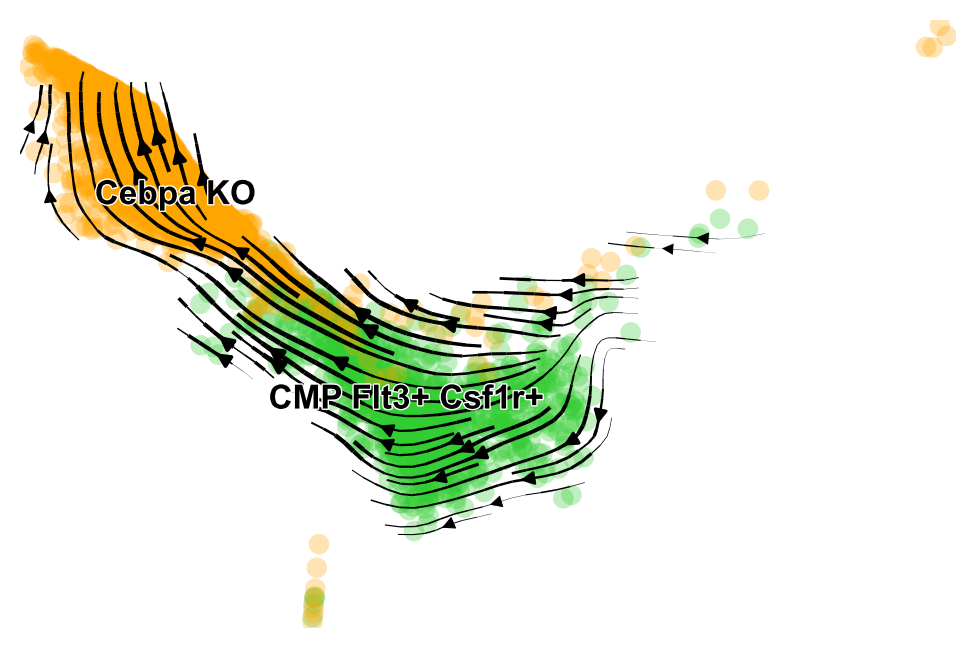

In [45]:
scv.pl.velocity_embedding_stream(cmp_cebpa_ko_adata, basis='umap', color="Batch_desc", layer="obs", palette=["limegreen", "orange"], title="")

## Cebpe KO

In [46]:
cmp_cebpe_ko_adata = adata[cmp_cells + cebpe_cells]

In [47]:
cmp_cebpe_ko_adata.shape

(1920, 4000)

In [48]:
batch_size = cmp_cebpe_ko_adata.shape[0] // 2

In [49]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

In [50]:
# Remove outgoing edges of Cebpa
cebpe_idx = mycellpop["gene"].name.index('Cebpe')
outgoing_cebpe_edges = (mycellpop['gene', 'regulates', 'gene'].edges[:, 0] == cebpe_idx)
mycellpop['gene', 'regulates', 'gene'].remove_edges(outgoing_cebpe_edges)

In [51]:
mycellpop.change_batch_size(batch_size)

In [52]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                             "trained_mycellpop_24_aug_5_2.pt"), 
                                map_location=torch.device('cpu'))

In [53]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

In [54]:
sc.pp.neighbors(cmp_cebpe_ko_adata, n_neighbors=30, n_pcs=50)

In [55]:
with torch.no_grad():
    
    cebpe_ko_velocities = []
        
    for i in tqdm(range(cmp_cebpe_ko_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cmp_cebpe_ko_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        velocity = mycellpop.get_derivatives(gene_expr)

        cebpe_ko_velocities.append(velocity)
        
cebpe_ko_velocities = torch.cat(cebpe_ko_velocities).cpu().numpy()[:, :, 0]
cmp_cebpe_ko_adata.layers["velocity"] = cebpe_ko_velocities
cmp_cebpe_ko_adata.layers["X"] = cmp_cebpe_ko_adata.X

100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


In [56]:
scv.tl.velocity_graph(cmp_cebpe_ko_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/1920 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


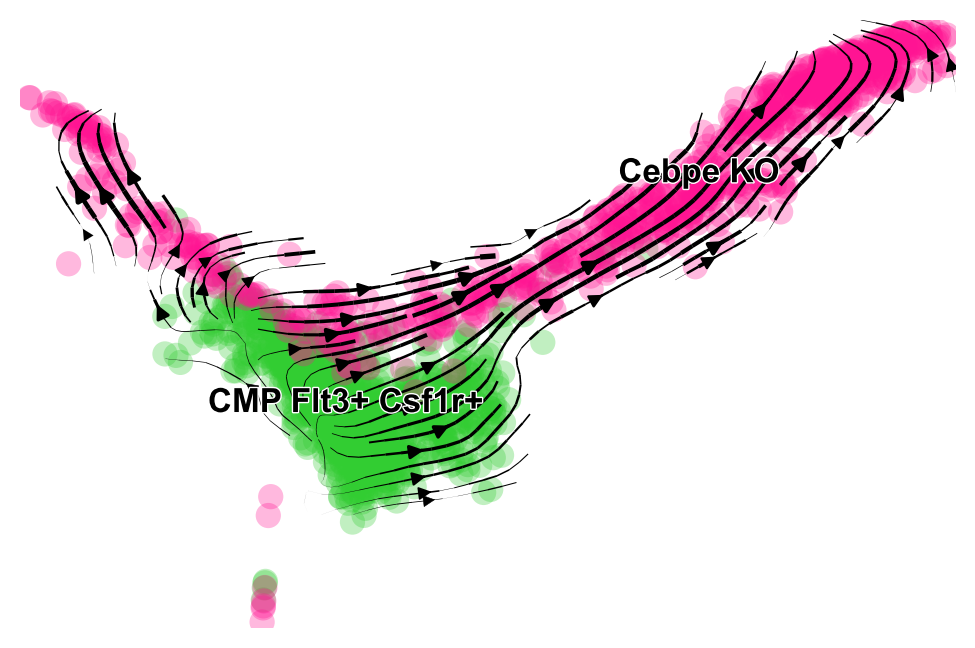

In [62]:
scv.pl.velocity_embedding_stream(cmp_cebpe_ko_adata, basis='umap', color="Batch_desc", layer="obs", palette=["limegreen", "deeppink"], title="")